# Initialisation steps 

## dependancies install

Process daily rainfall hosted on Google Earth Engine. 

## Authentification to GEE

In [1]:
import ee

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AY0e-g5yfgNaWsliNHpK04AeNLwJ7qBfDCYWWCD6OeEC7qstRPJ4QNHdWCo



Successfully saved authorization token.


# CHIRPS Processing 

[CHIRPS](https://www.chc.ucsb.edu/data/chirps) data is hosted (not uniquely) on Google Earth Engine. 

[chirps_gee](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)

As always with large data analysis we want to bring the compute to the data which is exactly one of the features of GEE. 
So most of the analysis will be performed on GEE and result downloaded. 

## Parameters Definition

In [3]:
gee_collection_id = "UCSB-CHG/CHIRPS/DAILY"
band_name = "precipitation"
aoi_url = 'https://github.com/matthieu-bernard/gee-processing/raw/main/gee_processing/data/aoi.geojson'

## Metadata collection

Google Actually publish SpatioTemporal Catalog Assets for the catalogs they host in GEE.

For now it seems like processing of the data with a Open Source platform (like Pangeo) is not there yet due to the 'proprietary' storage format they use. But lets at least salute the effort of publishing metadata to the STAC standard. 

[CHIRPS_stac_metadata](https://gee.stac.cloud/3cRrouu75vEzeP4uufqKgwzeubDQYizmMUQm?t=bands)

In [4]:
import intake

url = 'https://earthengine-stac.storage.googleapis.com/catalog/UCSB-CHG_CHIRPS_DAILY.json'
cat = intake.open_stac_catalog(url)
cat.metadata

{'stac_version': '1.0.0-beta.2',
 'stac_extensions': ['scientific', 'version'],
 'id': 'UCSB-CHG/CHIRPS/DAILY',
 'title': 'CHIRPS Daily: Climate Hazards Group InfraRed Precipitation with Station Data (version 2.0 final)',
 'version': '2.0',
 'gee:type': 'image_collection',
 'description': 'Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)\nis a 30+ year quasi-global rainfall dataset. CHIRPS incorporates\n0.05° resolution satellite imagery with in-situ station data\nto create gridded rainfall time series for trend analysis and seasonal\ndrought monitoring.\n',
 'license': 'proprietary',
 'keywords': ['chg',
  'climate',
  'geophysical',
  'precipitation',
  'ucsb',
  'weather'],
 'providers': [{'name': 'UCSB/CHG',
   'roles': ['producer', 'licensor'],
   'url': 'https://chc.ucsb.edu/data/chirps'},
  {'name': 'Google Earth Engine',
   'roles': ['host'],
   'url': 'https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY'}],
 'extent': {'spat

## Region of Interest

The CHIRPS dataset cover the all globe from -50 to +50. We are interested in a spatial subset.


In [5]:
# Read region of interest vector file
import geopandas as gpd

gpd_aoi = gpd.GeoDataFrame.from_file(aoi_url)
gjson = gpd_aoi.to_crs(epsg='4326').to_json()

In [6]:
# Really simple plot of the region of interest. 
# Just for the sake of control. 

import folium
import shapely
from typing import Tuple

def centroid(geom: shapely.geometry) -> Tuple[float, float]:
    centroid = geom.centroid
    return [centroid.y, centroid.x]


aoi_polygon = gpd_aoi['geometry'][0]
env = aoi_polygon.envelope 

mapa = folium.Map(centroid(aoi_polygon),
                  zoom_start=5,
                  tiles='cartodbpositron')

aoi = folium.features.GeoJson(gjson)
bbox = folium.features.GeoJson(env)

mapa.add_children(aoi)
folium.features.GeoJson(env).add_to(mapa)
mapa



<ipython-input-6-391d890f332f>:23: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  mapa.add_children(aoi)


In [7]:
print(env)

POLYGON ((103.9615961354011 41.28859028286109, 111.4537510007762 41.28859028286109, 111.4537510007762 44.77703004688289, 103.9615961354011 44.77703004688289, 103.9615961354011 41.28859028286109))


## Area of interets to GEE server

The area of interest need to be communicated to the GEE server for server-side computation. 

There seems to be 2 options here:
  - Pushing the shapefile to GEE assets
    - Manual upload from the GUI tool: https://developers.google.com/earth-engine/guides/importing
    - Use the cli to upload from GCS (cli is written in python so no need for a external call though https://github.com/google/earthengine-api/blob/7a6f605e1be30002c4a3ec516669703dea9e3f71/python/ee/cli/commands.py). 
  - Just construct an ee.Geometry from the Polygon (or a boundingBox if the shapefile is too big (or reduce it first...))  

Pushind files to GEE assets, either need a Google Cloud account or manual intervention in the pipeline. 
Creating a ee.Geomtry object is more flexible although it definitely have a the obvious drawback that we would send the geometry definiton over the network each time we run the pipeline. 


In [8]:
import os
import json

def geojson_to_ee(geo_json: str, geodesic=True) -> ee.Geometry:
    """Converts a geojson to ee.Geometry()
    Args:
        geo_json: geojson definition as str.
    Returns:
        ee_object: An ee.Geometry object
    """

    geo_json = json.loads(geo_json)
    features = ee.FeatureCollection(geo_json['features'])
    return features

In [9]:
aoi = geojson_to_ee(gjson)
#aoi_shp = ee.FeatureCollection('users/matthieu_bernard/aoi').geometry()

## GEE (Server side) processing pipeline

In [10]:
import datetime
import dateutil.parser
# Here we get the extent of the datastet to get all of it expect the data for the current 
# since a partial month could pollute or monthly statistics 


start = dateutil.parser.isoparse(cat.metadata['extent']['temporal']['interval'][0][0])
stop = datetime.date.today().replace(day=1)

# Select dataset of interest 
precip = ee.ImageCollection(gee_collection_id).select(band_name)

In [11]:
precip = (ee.ImageCollection(gee_collection_id)
          .select(band_name)
          .filter(ee.Filter.date(start.isoformat(), stop.isoformat()))  
         )

In [12]:
# Convert from daily precipitation values bin (rainy/not-rainy). 
precip_event = precip.map(lambda img: img.gt(0).copyProperties(img, img.propertyNames()))

In [13]:
# get sum of rainy days per month (one image per month per year)

months = ee.List.sequence(1, 12)
years = ee.List.sequence(start.year, stop.year)

by_month_year = ee.ImageCollection.fromImages(
  years.map(lambda y: months.map(lambda m:
        (precip_event
        .filter(ee.Filter.calendarRange(y, y, 'year'))
        .filter(ee.Filter.calendarRange(m, m, 'month'))
        .sum()
        .set('month', m).set('year', y))
                 
  )
).flatten())

In [14]:
# Get the monthly average over all years 

by_month = ee.ImageCollection.fromImages(
  months.map(lambda m:
        (by_month_year
        .filterMetadata('month', 'equals', m)
        .mean()
        .clip(aoi)
        .round()
        .set('month', m))
        .set('description', ('number of rainy days mean the number of days that have non null rainfall amount over'
                             'the aggregation period'))
        .set('aggregation_period', 'calendar_month')
        .set('long_name', 'number_of_rainy_days')
        .set('original_dataset', {k: cat.metadata[k] for k in ['title', 'description', 'version']})
        .set('provider', 'matth.bernard@gmail.com') 
  ))

In [15]:
images = by_month.toBands()

In [ ]:
def coord_list(geom):
    coords = list(geom.exterior.coords)
    return (coords)

tasks = []
for i in range(12):
    task = ee.batch.Export.image(images.select(f'{i}_precipitation'), f'monthly_average_rainy_days_{i+1:02d}',
      {
      'scale': 5000,
      'maxPixels': 1.0E13,
      'region': coord_list(gpd_aoi.geometry[0]),
      'fileFormat': 'GeoTIFF',
      'formatOptions': {
        'cloudOptimized': True
      },
      'folder': 'chirps'
    })
    task.start()
    tasks.append(task)   

## Visualisation 

Visualisation of the exported dataset 
Will also set metadata a bit better than what is done on the GEE side. 

### One file per month. Average number of rainy day (climato from 1981 to 2020)
Here I plot from local files already downloaded for the demonstration. 

In [16]:
import intake

local_cat = intake.cat()


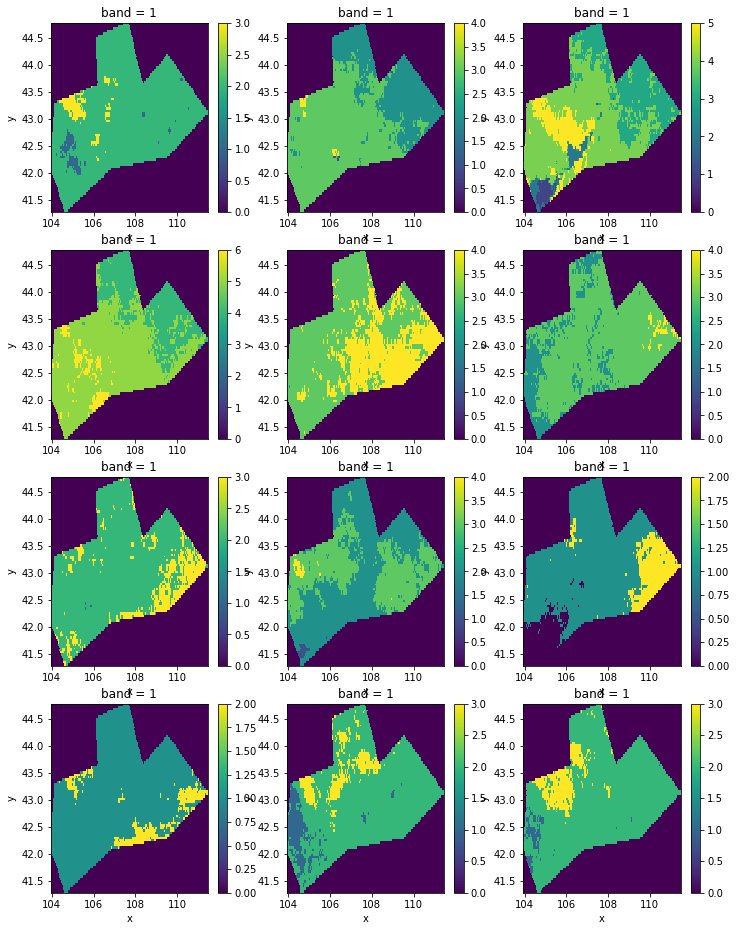

In [17]:
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline



f, axs = plt.subplots(4, 3, figsize=(12, 16))

for m in range(1,13):
    da=local_cat.gee.datasets.rainy_days_chirps_int(month=m).read() 
    da.plot(ax=axs.flatten()[m-1])

### One band per month. Average number of rainy day (climato from 1981 to 2020) as float

In [18]:
da = local_cat.gee.datasets.rainy_days_chirps().read()

In [19]:
da

<xarray.DataArray (band: 12, y: 78, x: 168)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * y        (y) float64 44.76 44.71 44.67 44.62 ... 41.43 41.39 41.34 41.3
  * x        (x) float64 104.0 104.0 104.0 104.1 ... 111.3 111.4 111.4 111.5
Attributes:
    transform:      (0.04491576420597607, 0.0, 103.93507837262864, 0.0, -0.04...
    crs:            +init=epsg:4326
    res:            (0.04491576420597607, 0.04491576420597607)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    descriptions:   ('0_precipitation', '1_precipitation', '2_precipitation',...
    AREA_OR_POINT:  Area

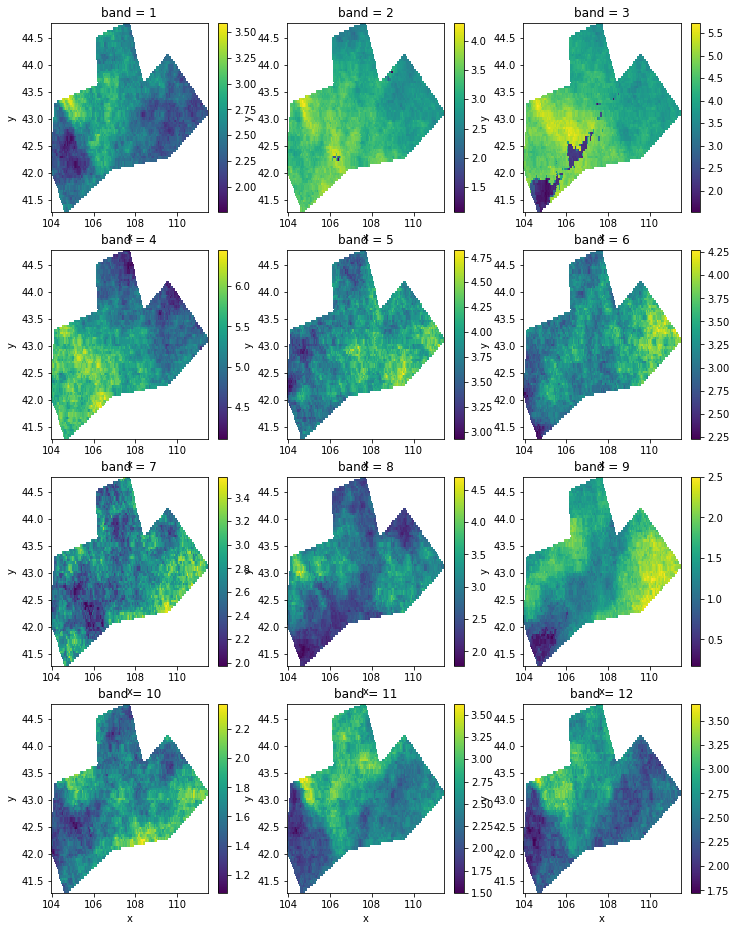

In [20]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline


f, axs = plt.subplots(4, 3, figsize=(12, 16))

for band in range(12):
    da.isel(band=band).plot(ax=axs.flatten()[band])

### Metadata filling

In [22]:
!pip install rioxarray

In [32]:
da.attrs.update({
'description': ('number of rainy days mean the number of days that have non null rainfall amount over'
                'the :ggregation period'),
'aggregation_period': 'calendar_month',
'long_name': 'number_of_rainy_days',
'original_dataset': {k: cat.metadata[k] for k in ['title', 'description', 'version']},
'provider': 'matth.bernard@gmail.com',
})

In [38]:
# Here we should save to the raster nut for the sake of showing that attributes are not exported by GEE

import rioxarray
da.rio.to_raster('/tmp/test.tif')

In [34]:
da

<xarray.DataArray (band: 12, y: 78, x: 168)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * y        (y) float64 44.76 44.71 44.67 44.62 ... 41.43 41.39 41.34 41.3
  * x        (x) float64 104.0 104.0 104.0 104.1 ... 111.3 111.4 111.4 111.5
Attributes: (12/14)
    transform:           (0.04491576420597607, 0.0, 103.93507837262864, 0.0, ...
    crs:                 +init=epsg:4326
    res:                 (0.04491576420597607, 0.04491576420597607)
    is_tiled:            1
    nodatavals:          (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:              (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    ...                  ...
    AREA_OR_POINT:       Area
    description:         number of rainy days mean the number of days that ha...
    aggregation_period:  calendar_month
    long_name:           number_of_rainy_days
    original_dataset:    {'title': 'CHIRPS Daily: Climate Hazards Group Infra...
    provider:            matth.bernard@gmail.com

In [39]:
import xarray as xr
rio = xr.open_rasterio("/tmp/test.tif")


In [40]:
rio

<xarray.DataArray (band: 12, y: 78, x: 168)>
[157248 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * y        (y) float64 44.76 44.71 44.67 44.62 ... 41.43 41.39 41.34 41.3
  * x        (x) float64 104.0 104.0 104.0 104.1 ... 111.3 111.4 111.4 111.5
Attributes: (12/14)
    transform:           (0.044915764205976115, 0.0, 103.93507837262864, 0.0,...
    crs:                 +init=epsg:4326
    res:                 (0.044915764205976115, 0.04491576420597602)
    is_tiled:            0
    nodatavals:          (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:              (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    ...                  ...
    aggregation_period:  calendar_month
    AREA_OR_POINT:       Area
    description:         number of rainy days mean the number of days that ha...
    long_name:           number_of_rainy_days
    original_dataset:    {'title': 'CHIRPS Daily: Climate Hazards Group Infra...
    provider:            matth.bernard@gmail.com